A written summary of this notebook can be found here:
    <a href="https://docs.google.com/document/d/1IwEJG9dk8pRHBeDzMarifRONW3Vl7PrPjvVlc-kS9cs/edit#">
       Google Doc </a>

# Downloading the necessary packages and data

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [146]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
main_df=pd.read_pickle('../may22-lunar-outpost/Data/df_of_imdb_data.pkl')

# One-hot encoding the important info

## Countries:
    one column
    1 if domestic (United States) and 0 otherwise
    
The function `countries_onehot` can be used to quickly change the number of countries

In [5]:
#countries
def countries_onehot(df, country_list):
    '''inputs a movie dataframe (df) and a list of countries as strings (country_list)
    output a movie dataframe with extra columns with :
    title of each column is the country,  
    gives a 1 if the country appears in the country list, and 0 otherwise'''
    new_df=df.copy()
    for country in country_list:
        binary_list =[]
        for i in range(len(df)):
            if country in df.iloc[i]['countries']: 
                #Right now, this encodes EVERY country listed, not just the most important one
                binary_list.append(1)
            else:
                binary_list.append(0)
        new_df[country] = binary_list
    return new_df

## Genres
    5 columns
        -Family
        -Adventure
        -Comedy
        -Fantasy
        -Other
    Has 1 if included as one of the genres, and 0 otherwise
    To change the number of genres included, we need to edit `genres_onehot` directly.  The possible genres are 
    
        Animation, Family, Adventure, Comedy, Fantasy, Action, Drama,           
        Sci-Fi, Romance, Mystery, Thriller, Musical, Horror, Crime,            
        Music, History, War, Sport, Biography, Western, Documentary, Game-Show

In [7]:
def genres_onehot(df):
    '''input the dataframe of movie info (df)
    outputs dataframe:
    a dataframe with imdb_id,  one-hot encoding for genres EXCEPT animation and 'Other' category for smaller genres'''
    genres_df= pd.DataFrame({
                        'Family':[],
                        'Adventure':[] ,
                        'Comedy':[],
                        'Fantasy':[],
#                        'Action':[],
#                        'Drama':[],
#                        'Sci-Fi':[],
                        'Other':[]
                            })
    for i in range(0, len(df)):
        row=df.iloc[i]
        newrow=pd.DataFrame({
                        'Family':[0],
                        'Adventure':[0] ,
                        'Comedy':[0],
                        'Fantasy':[0],
#                        'Action':[0],
#                        'Drama':[0],
#                        'Sci-Fi':[0],
                        'Other':[0]
                            })
        
        for genre in row['genres']:
            if genre == 'Animation':
                pass
            elif genre not in ['Family',
                               'Adventure',
                               'Comedy',
                               'Fantasy',
#                               'Action', 
#                               'Drama',
#                               'Sci-Fi'
                              ]:
                newrow.iloc[0, newrow.columns.get_loc('Other')] = int(1)
            else:
                newrow.iloc[0, newrow.columns.get_loc(genre)] = int(1)
        genres_df=pd.concat([genres_df, newrow],ignore_index=True )
    return(pd.concat([df,genres_df],axis=1))

## Certificates

In [9]:
#This is a helper function
#We create a list of ratings for the movies, using G, PG, PG-13, R to classify them (rough equivalents to TV ratings)
#For our purposes, NC-17 is rated R
def process_ratings(df):
    '''inputs a dataframe (df) of movies
    outputs a list of the US ratings'''
    ratings = ['pending' for i in range(len(df))]

    for i in range(len(df)):
        #if ratings[i] == 'pending':
            for rating in df.iloc[i]['certificates']:
                if 'United States' ==rating[0:13]:
                    #print(rating)
                    if 'United States:G' in rating:
                        ratings[i] = 'G'
                    elif 'United States:TV-G' in rating:
                        ratings[i] = 'G'
                    elif 'United States:TV-Y' in rating:
                        ratings[i]='PG'
                    elif 'United States:PG-13' in rating:
                        ratings[i]='PG-13'
                    elif 'United States:PG' in rating:
                        ratings[i]='PG' #ORDER HERE IS IMPORTANT!
                        #print('this is normal')
                    elif 'United States:TV-PG' in rating:
                        ratings[i] = 'PG'
                    elif 'United States:TV-14' in rating:
                        ratings[i] = 'PG-13'
                    elif 'United States:R' in rating:
                        ratings[i] = 'R'
                    elif 'United States:TV-MA' in rating:
                        ratings[i]='R'
                    elif 'United States:M' in rating:
                        ratings[i]='R'
                        #print('uh oh!')
                    elif 'United States:NC-17' in rating:
                        ratings[i] = 'R'
    for i in range(len(df)):
        if ratings[i] =='pending':
            ratings[i] ='Unrated'
    return ratings

In [10]:
#Get the one-hot encoded values
def certificates_onehot(df):
    '''input a movie dataframe, output a movie dataframe with the
    US ratings one-hot encoded'''
    
    parsed_ratings=process_ratings(df)
    temp_df=pd.DataFrame({'pr': parsed_ratings})
    
    temp_df2 = pd.get_dummies(temp_df['pr'])
    return(pd.concat([df, temp_df2], axis=1))

## Metascores

In [12]:
def metascore_onehot(df):
    '''inputs a dataframe (df) and outputs a dataframe with an extra column
    1 if it has a metascore, 0 otherwise'''
    metascore_column=[]
    new_df=df.copy()
    for i in range(len(df)):
        if df.iloc[i]['metascore']['data'] == {}:
            metascore_column.append(0)
        else:
            metascore_column.append(1)
    new_df['metascore_available']=metascore_column
    return(new_df)
            

## Making the new dataframe

In [66]:
main_df=countries_onehot(main_df, ['United States'])
main_df=genres_onehot(main_df)
main_df=certificates_onehot(main_df)
main_df=metascore_onehot(main_df)

main_df.head()

,imdb_id,titles,year,original_air_date,countries,language,genres,certificates,rating,votes,...,Adventure,Comedy,Fantasy,Other,G,PG,PG-13,R,Unrated,metascore_available
0,0388130,Initial D: Third Stage,2001,13 Jan 2001 (Japan),[Japan],"[en, ja, cmn]","[Animation, Action, Romance, Sport]","[Australia:PG, Japan:G, United States:TV-PG]",7.6,1390,...,0.0,0.0,0.0,1.0,0,1,0,0,0,0
1,0273772,Don't Make Trouble!,2001,17 Jan 2001 (France),[France],"[fr, ar]","[Animation, Drama, Comedy]",[France:Tous publics],6.6,49,...,0.0,1.0,0.0,1.0,0,0,0,0,1,0
2,0243017,Waking Life,2001,07 Mar 2002 (Australia),[United States],[en],"[Animation, Drama, Fantasy]","[Argentina:13, Australia:M, Brazil:Livre, Cana...",7.7,63692,...,0.0,0.0,1.0,1.0,0,0,0,1,0,1
3,0291559,Wave Twisters,2001,[],[United States],[en],"[Animation, Adventure, Musical, Sci-Fi]",[United States:Unrated],7.4,551,...,1.0,0.0,0.0,1.0,0,0,0,0,1,0
4,0277909,Mutant Aliens,2001,09 Jan 2002 (France),[United States],[en],"[Animation, Comedy, Sci-Fi]","[France:Tous publics, Germany:16, South Korea:...",6.6,1204,...,0.0,1.0,0.0,1.0,0,0,0,1,0,1


In [15]:
main_df[main_df['imdb_id']=='10172802']

,imdb_id,titles,year,original_air_date,countries,language,genres,certificates,rating,votes,...,Adventure,Comedy,Fantasy,Other,G,PG,PG-13,R,Unrated,metascore_available
3107,10172802,Outlander - IMDb,[],04 Jul 2019 (Australia),[United States],[en],[Animation],[Australia:M],[],[],...,0.0,0.0,0.0,0.0,0,0,0,0,1,0


In [16]:
main_df.at[3107,'year']=2019

In [17]:
main_df.to_pickle('../may22-lunar-outpost/Data/Data_from_imdb_onehot1.pkl')

# Splitting the test and training data

In [18]:
main2=pd.read_pickle('Data/Data_from_imdb_onehot1.pkl')

In [19]:
main2.head()

,imdb_id,titles,year,original_air_date,countries,language,genres,certificates,rating,votes,...,Adventure,Comedy,Fantasy,Other,G,PG,PG-13,R,Unrated,metascore_available
0,0388130,Initial D: Third Stage,2001,13 Jan 2001 (Japan),[Japan],"[en, ja, cmn]","[Animation, Action, Romance, Sport]","[Australia:PG, Japan:G, United States:TV-PG]",7.6,1390,...,0.0,0.0,0.0,1.0,0,1,0,0,0,0
1,0273772,Don't Make Trouble!,2001,17 Jan 2001 (France),[France],"[fr, ar]","[Animation, Drama, Comedy]",[France:Tous publics],6.6,49,...,0.0,1.0,0.0,1.0,0,0,0,0,1,0
2,0243017,Waking Life,2001,07 Mar 2002 (Australia),[United States],[en],"[Animation, Drama, Fantasy]","[Argentina:13, Australia:M, Brazil:Livre, Cana...",7.7,63692,...,0.0,0.0,1.0,1.0,0,0,0,1,0,1
3,0291559,Wave Twisters,2001,[],[United States],[en],"[Animation, Adventure, Musical, Sci-Fi]",[United States:Unrated],7.4,551,...,1.0,0.0,0.0,1.0,0,0,0,0,1,0
4,0277909,Mutant Aliens,2001,09 Jan 2002 (France),[United States],[en],"[Animation, Comedy, Sci-Fi]","[France:Tous publics, Germany:16, South Korea:...",6.6,1204,...,0.0,1.0,0.0,1.0,0,0,0,1,0,1


In [20]:
#create a dataframe that drops given years
def drop_test(df,L):
    '''input a dataframe of movies (df) and a list of years as int (L)
    outputs a dataframe that does not include the movies in years in L'''
    indices =[]
    for i in range(len(df)):
        if df.iloc[i]['year'] in L:
            indices.append(i)
    new_df=df.drop(indices)
    return(new_df)

#main2.drop([0, 1])

In [21]:
train_set=drop_test(main2, [2018,2019,2020,2021])

# Finally making the model based on genres, certificates, domestic, and metascore availability

### Splitting the validation data

In [79]:
def timeseries_split(df, k):
    '''takes in a movie dataframe (df),  k (int)
    and outputs a tuple that behaves like kfold.split when kfold =kfold = TimeSeriesSplit(n_splits = k,
                           test_size = 1)
    that is, the output is a tuple of 2-tuples, where
    the first element of each tuple is the indices of the train set and
    the second element is the indices of the test set
    unlike TimeSeriesSplit it can only handle one dataframe at a time'''
    if len(df['year'].value_counts()) <k:
        #print('Error: dataframe too small for k and test size')
        raise ValueError("Not enough data for given k")
        
    df=df.copy()
    
    answer=[]
    i=0
    while i <k:
        last_year=df['year'].max()
        
        #get array of indices of last year in list
        index_set=np.array(df[df['year']==last_year].index)
        
        #add these to test_sets
        #test_sets=[index_set] + test_sets
        
        #delete rows from dataframe
        df=drop_test(df,[last_year])
        #print(len(df))
        
        #add to train_sets
        index_set2=np.array(df.index)
        #print((index_set2))
        #train_sets=[index_set2]+train_sets
        
        new_set=(index_set2, index_set)
        answer=[new_set] + answer
        
        i=i+1
    
    return tuple(answer)

#Output 2 lists
#first list is a list of arrays of training indices
#second list is a list of arrays of testing indices

In [80]:
#for testing that it works just like kfold.split
#kfold = TimeSeriesSplit(n_splits = 5, test_size = 14)

for train_index, test_index in timeseries_split(main2,5):
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    print()
    print()

TRAIN INDEX: [   0    1    2 ... 2387 2388 2389]
TEST INDEX: [2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403
 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413 2414 2415 2416 2417
 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427 2428 2429 2430 2431
 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445
 2446 2447 2448 2449 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459
 2460 2461 2462 2463 2464 2465 2466 2467 2468 2469 2470 2471 2472 2473
 2474 2475 2476 2477 2478 2479 2480 2481 2482 2483 2484 2485 2486 2487
 2488 2489 2490 2491 2492 2493 2494 2495 2496 2497 2498 2499 2500 2501
 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515
 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527 2528 2529
 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541 2542 2543
 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557
 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571
 2572 2573 2574 

### Decision Tree

In [77]:
train_set.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available'],
      dtype='object')

Now we do a cross validation to find a good value for max_depth

In [100]:
def est_decision_tree(j):
    '''goes through j max_depth values on decision trees on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        k=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make decision tree with maxdepth i+1
            tree=DecisionTreeClassifier(max_depth=1*(i+1))
            tree.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=tree.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,k]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,k]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            k=k+1

    return(precs, recs)

In [119]:
metrics1=est_decision_tree(10)

In [120]:
metrics1

(array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.        , 0.        , 0.        , 1.        ],
        [0.33333333, 0.        , 0.        , 1.        , 1.        ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.       

Shall we make a pretty picture? Maybe later

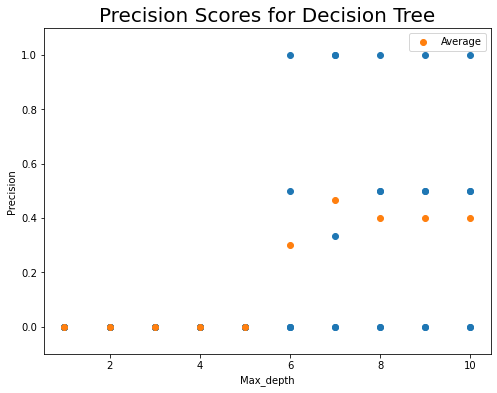

In [224]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics1[0]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics1[0], axis=1), label='Average')

plt.title('Precision Scores for Decision Tree', fontsize=20)
plt.xlabel('Max_depth')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

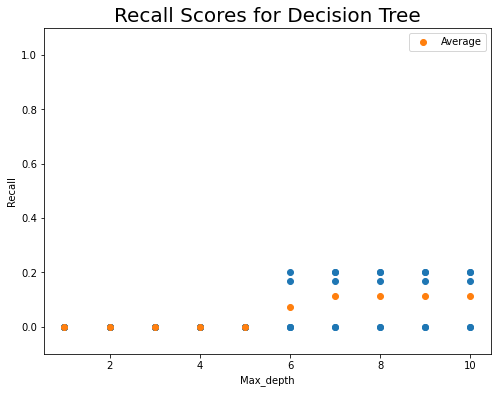

In [225]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics1[1]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics1[1], axis=1), label='Average')

plt.title('Recall Scores for Decision Tree', fontsize=20)
plt.xlabel('Max_depth')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [219]:
print('Recall:')
print(np.mean(metrics1[1], axis=1)[9])
print('Precision:')
print(np.mean(metrics1[0], axis=1)[9])

Recall:
0.11333333333333333
Precision:
0.4


#### <font color='MediumOrchid'>For Decision Trees, both precision and recall seem to level out after max_depth 8.  Let's call this 10 for good measure.  So, the best (for now) Decision Tree Classifier is: </font>

In [105]:
tree=DecisionTreeClassifier(max_depth=10)

tree.fit(train_set[['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
        train_set['is_nominee']
        )

DecisionTreeClassifier(max_depth=10)

### k Nearest Neighbors Classifier

In [110]:
def est_knn(j):
    '''goes through k in range(1,j+1) on kNN models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1*(i+1))
            kNN.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=kNN.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [121]:
metrics2=est_knn(5)

In [122]:
metrics2

(array([[0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.5       , 0.5       , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.        , 0.        , 0.5       ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([[0.33333333, 0.4       , 0.66666667, 0.4       , 0.2       ],
        [0.16666667, 0.2       , 0.        , 0.        , 0.        ],
        [0.16666667, 0.2       , 0.        , 0.        , 0.2       ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]))

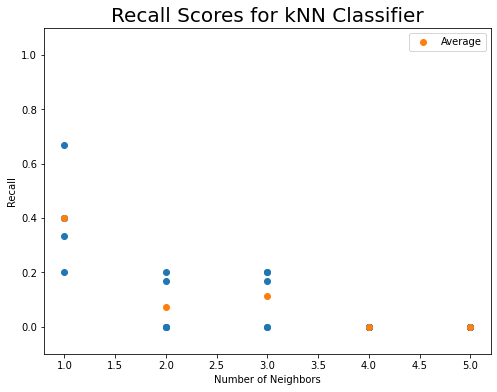

In [226]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(metrics2[1]).reshape(1,-1))

plt.scatter(range(1,6), np.mean(metrics2[1], axis=1), label='Average')

plt.title('Recall Scores for kNN Classifier', fontsize=20)
plt.xlabel('Number of Neighbors')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

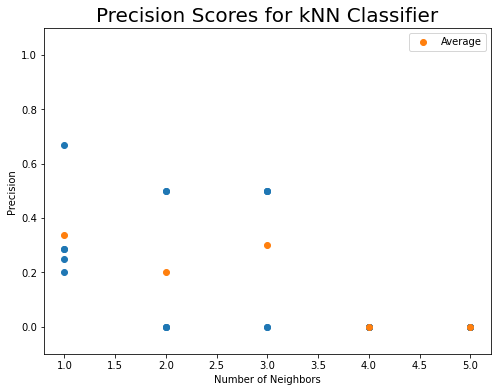

In [227]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(metrics2[0]).reshape(1,-1))

plt.scatter(range(1,6), np.mean(metrics2[0], axis=1), label='Average')

plt.title('Precision Scores for kNN Classifier', fontsize=20)
plt.xlabel('Number of Neighbors')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [221]:
print('Recall:')
print(np.mean(metrics2[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics2[0], axis=1)[0])

Recall:
0.39999999999999997
Precision:
0.3376190476190476


#### <font color='MediumOrchid'>For k Nearest Neighbors, the more neighbors the worse off we are.  This actually may make sense because so few movies are nominated for Oscars that if we take more than 3 neighbors, we're predicting that no movies are nominated, ever. Overall, it seems we really should take one neighbor.  Thus, the best (for now) k Nearest Neighbors model is:</font>

In [118]:
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(
        train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
        train_set.iloc[train_index]['is_nominee']
        )

KNeighborsClassifier(n_neighbors=1)

As a future direction, I'd like to play with the metric kNN is using

### Support Vector Machine - linear and non-linear

I doubt it will be any good, but let's try a linear SVC for fun.

In [127]:
def est_linear_svc(j):
    '''goes through C in 1/2^range(j) on linear SVC models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make Linear SVC model with C=1/2^j
            svc = LinearSVC(C=2**(-1*j))
            svc.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [129]:
metrics3=est_linear_svc(5)

In [130]:
metrics3

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))

Yup. Terrible.  Let's try non-linear versions.

In [133]:
def est_rbf_svc(j):
    '''goes through C in range(j) on SVC models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*j), kernel='rbf', max_iter=10000)
            svc.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [134]:
metrics4= est_rbf_svc(10)

In [135]:
metrics4

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))

In [137]:
def est_sig_svc(j):
    '''goes through C in range(j) on SVC models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*j), kernel='sigmoid', max_iter=10000)
            svc.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [138]:
metrics5=est_sig_svc(10)

In [139]:
metrics5

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))

In [143]:
def est_poly_svc(j,n):
    '''goes through C in range(j) on SVC models on training set.
    with polynomial degree n
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*j), kernel='poly', degree=n, max_iter=10000)
            svc.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [144]:
metrics6=[]
for i in range(10):
    metrics=est_poly_svc(10,i)
    metrics6.append(metrics)
    print('i=', str(i))
    print(metrics[0])
    print(metrics[1])
    print()
    print('============================')
    

i= 0
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

i= 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

i= 2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0

#### <font color='MediumOrchid'>For Support Vector Machines, there were no correct predictions.  So, I will not use them moving forward.</font>

# A Voting Model based on the above

In [ ]:
voting = VotingClassifier([
    ('knn', KNeighborsClassifier(1)),
    ('tree', DecisionTreeClassifier(max_depth=10))
])

voting.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )

In [166]:
def voting(n):
    '''n = weights of the voting model
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((n,5))
    recs = np.zeros((n,5))
    for i in range(0,n):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make voting model 
            voting = VotingClassifier([
                ('knn', KNeighborsClassifier(1)),
                ('tree', DecisionTreeClassifier(max_depth=10))
                                    ],
                weights=[1,i])
            voting.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [167]:
metrics7=voting(1)

In [168]:
metrics7

(array([[0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ]]),
 array([[0.33333333, 0.4       , 0.66666667, 0.4       , 0.2       ]]))

In [169]:
metrics8=voting(10)

In [170]:
metrics8

(array([[0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.5       , 0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 1.        , 0.5       ]]),
 array([[0.33333333, 0.4       , 0.66666667, 0.4       , 0.2       ],
        [0.16666667, 0.        , 0.        , 0.        , 0.        ],
        [0.16666667, 0.        , 0.        , 0.2       , 0.2       ],
        [0.16666667, 0.        , 0.        , 0.2       , 0.2       ],
        [0.1666666

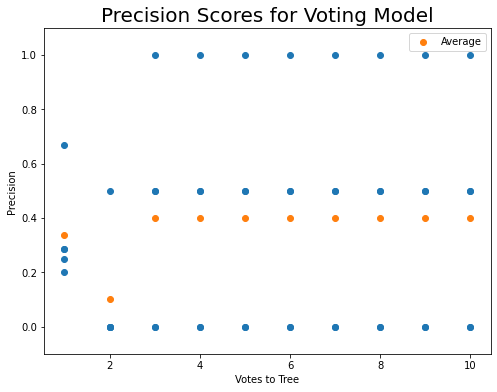

In [230]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics8[0]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics8[0], axis=1), label='Average')

plt.title('Precision Scores for Voting Model', fontsize=20)
plt.xlabel('Votes to Tree')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

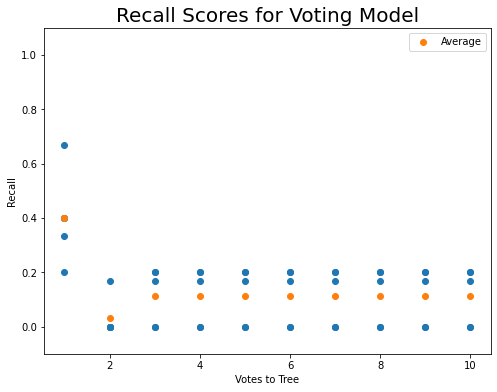

In [229]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics8[1]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics8[1], axis=1), label='Average')

plt.title('Recall Scores for Voting Model', fontsize=20)
plt.xlabel('Votes to Tree')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [228]:
print('Recall:')
print(np.mean(metrics8[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics8[0], axis=1)[0])

Recall:
0.39999999999999997
Precision:
0.3376190476190476


In [214]:
def voting2(n):
    '''n = weights of the voting model
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((n,5))
    recs = np.zeros((n,5))
    for i in range(0,n):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make voting model 
            voting = VotingClassifier([
                ('knn', KNeighborsClassifier(1)),
                ('tree', DecisionTreeClassifier(max_depth=10))
                                    ],
                weights=[i,1])
            voting.fit(
                train_set.iloc[train_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
                                           'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available']],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(train_set.iloc[val_index][['United States', 'Family', 'Adventure', 'Comedy', 'Fantasy',
                                                         'Other','G', 'PG', 'PG-13', 'R', 'Unrated',
                                                         'metascore_available']]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [235]:
metrics9=voting2(10)

In [236]:
metrics9

(array([[0.5       , 0.        , 0.        , 1.        , 0.5       ],
        [0.5       , 0.        , 0.        , 0.        , 0.        ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ],
        [0.28571429, 0.66666667, 0.25      , 0.28571429, 0.2       ]]),
 array([[0.16666667, 0.        , 0.        , 0.2       , 0.2       ],
        [0.16666667, 0.        , 0.        , 0.        , 0.        ],
        [0.33333333, 0.4       , 0.66666667, 0.4       , 0.2       ],
        [0.33333333, 0.4       , 0.66666667, 0.4       , 0.2       ],
        [0.3333333

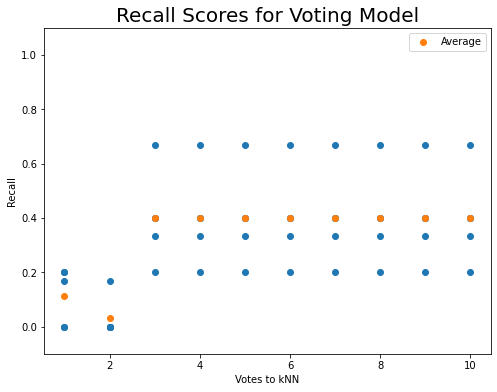

In [237]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics9[1]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics9[1], axis=1), label='Average')

plt.title('Recall Scores for Voting Model', fontsize=20)
plt.xlabel('Votes to kNN')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

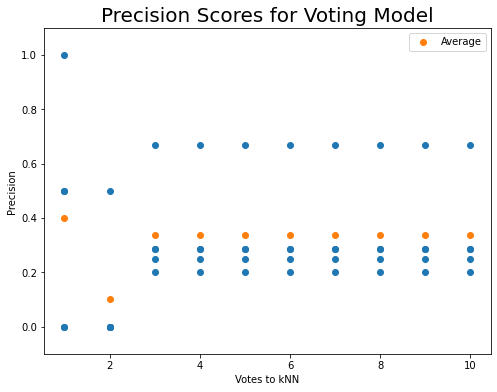

In [238]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics9[0]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics9[0], axis=1), label='Average')

plt.title('Precision Scores for Voting Model', fontsize=20)
plt.xlabel('Votes to kNN')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [241]:
print('Recall:')
print(np.mean(metrics9[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics9[0], axis=1)[0])

Recall:
0.11333333333333333
Precision:
0.4


In [242]:
print('Recall:')
print(np.mean(metrics9[1], axis=1)[2])
print('Precision:')
print(np.mean(metrics9[0], axis=1)[2])

Recall:
0.39999999999999997
Precision:
0.3376190476190476
